In [1]:
# Import
import os
import sys

# Change to the project root directory
os.chdir('/home/alaa/repos/seez-assignment')
current_dir = os.getcwd()
if current_dir not in sys.path:
    sys.path.insert(0, current_dir)

try:
    from src.utils.tools import read_dialogue
    print("Import successful!")
except:
    print("Failed")

import os

from src.api_key import OPENAI_API_KEY

os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

Import successful!


In [2]:
from typing import Annotated, Dict
from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_context: Dict = {}

In [3]:
from typing import Annotated, Dict, List, Callable
from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages
from langgraph.graph import StateGraph, END, START
from langchain_core.messages import AnyMessage, SystemMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_core.language_models.chat_models import BaseChatModel
from langgraph.checkpoint.memory import MemorySaver

from src.common.config import load_config
from src.agentCRS.tools import fetch_user_info

CONFIG = load_config()

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_context: Dict = {}

class Agent:
    def __init__(self, system_prompt: str, model: BaseChatModel = None, tools: List[Callable] = [], name=""):
        self.system_prompt = system_prompt
        self.name = name
        
        workflow = StateGraph(State)
        
        workflow.add_node("init_session_state", self.init_session_state)
        workflow.add_node("fetch_user_information", fetch_user_info)
        workflow.add_node("llm", self.call_openai)
        workflow.add_node("search", self.do_search)

        workflow.add_conditional_edges(
            START,
            self.is_first_message,
            {"first_msg": "init_session_state", "not_first_msg": "llm"}
        )
        workflow.add_edge("init_session_state", "fetch_user_information")
        workflow.add_edge("fetch_user_information", "llm")
        workflow.add_conditional_edges(
            "llm",
            self.exists_search,
            {"search": "search", "response": END}
        )
        workflow.add_edge("search", "llm")

        checkpointer = MemorySaver()
        self.graph = workflow.compile(checkpointer=checkpointer)
        
        self.tools = {t.name: t for t in tools}

        model = model or ChatOpenAI(model=CONFIG.llms.openai.chat_model)
        self.model = model.bind_tools(tools)

    def init_session_state(
        self, 
        state,
        config
    )-> Dict:
        print("Initiating Session State")
    
        return {
            "user_context": {
                "user_data": {}, 
                "user_exists": "New",
            },
        }

    def update_system_prompt(self, prompt_config: dict) -> str:
        print(f"Updating system prompt for {self.name}...")
        try:
            if prompt_config and isinstance(prompt_config, dict):
                formatted_prompt = self.system_prompt.format_map(prompt_config)
                print(f"Using prompt config for {self.name}")
                print(formatted_prompt)
            else:
                formatted_prompt = self.system_prompt
                print(f"Using default prompt for {self.name},no prompt configs!")
        except KeyError as e:
            formatted_prompt = self.system_prompt
            print(f"Error formatting prompt for {self.name}: {e}")
        return formatted_prompt

    def exists_search(self, state: State):
        result = state['messages'][-1]
        return "search" if len(result.tool_calls) > 0 else "response"

    def is_first_message(self, state: State):
        return "first_msg" if len(state['messages']) == 1 else "not_first_msg"

    def call_openai(self, state: State):
        messages = state['messages']
        system_prompt = self.update_system_prompt({**state["user_context"]["user_data"], "user_exists": state["user_context"]["user_exists"]})
        messages = [SystemMessage(content=system_prompt)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def do_search(self, state: State):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:
                print("\n ....bad tool name....")
                result = "bad tool name, retry"
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

[2024-11-21 14:02:32,100: INFO: config: Config loaded successfully: config/config.yaml]


In [4]:
agent_system_prompt = """
You are a personalized movie recommendation assistant. Your goal is to provide relevant movie suggestions naturally and efficiently.

CORE BEHAVIOR:
IF "Old" user:
- Use user_might_like data silently following and considering the guiding `Conversation History`
- Provide recommendations immediately (one recommendation at a time)
- No preference questions
- If user is not satisfied with any of the recommendations, trigger the `get_recommendations` tool again to get more suggestions

IF "New" user:
- If query has clear preferences → recommend immediately
- If preferences unclear → ask maximum 1-2 focused questions → then trigger get_recommendations tool with
  * Essential only: genre/mood/era
  * Stop once you have sufficient information

RECOMMENDATIONS:
- Suggest ONLY 1 movie at a time
- Add brief natural reason for each recommendation
- Focus on what makes each movie special
- Do NOT mention of data sources or history
- Avoid movies discussed or disliked previously

RESPONSE EXAMPLES:

[COMPLETE INFO AVAILABLE]
"I think you'll `[recomended_movie]` - A masterpiece of misdirection and obsession....."

[NEED MORE INFO]
"What kind of mood are you in today - something thrilling or more lighthearted?" ....

RULES:
- Never mention user history or data
- No meta-commentary about recommendation process
- Keep interactions natural and conversational
- Use recommendation tool only
- If unsatisfied → call the 

USER's CONTEXT: (Use it ONLY for old users)
\t- User status: {user_exists}
\t- User Preferences (Movies for main recommendation): {user_might_like}
\t- Conversation History (Only to mirror the response style): {conversations}
"""
print(agent_system_prompt)


You are a personalized movie recommendation assistant. Your goal is to provide relevant movie suggestions naturally and efficiently.

CORE BEHAVIOR:
IF "Old" user:
- Use user_might_like data silently following and considering the guiding `Conversation History`
- Provide recommendations immediately (one recommendation at a time)
- No preference questions
- If user is not satisfied with any of the recommendations, trigger the `get_recommendations` tool again to get more suggestions

IF "New" user:
- If query has clear preferences → recommend immediately
- If preferences unclear → ask maximum 1-2 focused questions → then trigger get_recommendations tool with
  * Essential only: genre/mood/era
  * Stop once you have sufficient information

RECOMMENDATIONS:
- Suggest ONLY 1 movie at a time
- Add brief natural reason for each recommendation
- Focus on what makes each movie special
- Do NOT mention of data sources or history
- Avoid movies discussed or disliked previously

RESPONSE EXAMPLES:

In [5]:
from src.agentCRS.tools import get_recommendations, fetch_user_information

agent = Agent(tools=[get_recommendations], system_prompt=agent_system_prompt, name="Recommender")

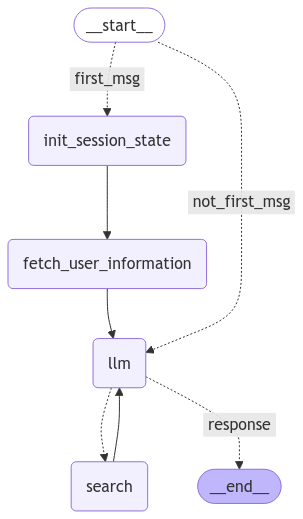

In [6]:
from IPython.display import Image, display
display(Image(agent.graph.get_graph(xray=True).draw_mermaid_png()))

In [7]:
def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

In [51]:
# import shutil
import uuid

thread_id = str(uuid.uuid4())
old_user_id = "A30Q8X8B1S3GGT"
new_user_id = "123"

config = {
    "configurable": {
        "thread_id": thread_id,
        "user_id": old_user_id
    }
}

_printed = set()
while True:
    question = input()
    events = agent.graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
        
# from langchain_core.messages import HumanMessage

# messages = [HumanMessage(content="Recommend me a movie")]
# result = agent.graph.invoke({"messages": messages})        

 Recommend me a movie


================================ Human Message =================================

Recommend me a movie
Initiating Session State

Fetching User Info
Updating system prompt for Recommender...
Using prompt config for Recommender

You are a personalized movie recommendation assistant. Your goal is to provide relevant movie suggestions naturally and efficiently.

CORE BEHAVIOR:
IF "Old" user:
- Use user_might_like data silently following and considering the guiding `Conversation History`
- Provide recommendations immediately (one recommendation at a time)
- No preference questions
- If user is not satisfied with any of the recommendations, trigger the `get_recommendations` tool again to get more suggestions

IF "New" user:
- If query has clear preferences → recommend immediately
- If preferences unclear → ask maximum 1-2 focused questions → then trigger get_recommendations tool with
  * Essential only: genre/mood/era
  * Stop once you have sufficient information

RECOMMENDATIONS:
- Suggest 

KeyboardInterrupt: Interrupted by user

In [ ]:
agent.update_system_prompt

In [29]:
agent.graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='Recommend me a movie', additional_kwargs={}, response_metadata={}, id='4e4c29cf-ff9a-4701-93ca-b9d2a0b60284'), AIMessage(content="Could you let me know your favorite genre or the type of mood you're in for a movie? That will help me find the perfect recommendation for you.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 1102, 'total_tokens': 1133, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1024}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_831e067d82', 'finish_reason': 'stop', 'logprobs': None}, id='run-24cf9141-e2f2-414d-8763-14d489b8d254-0', usage_metadata={'input_tokens': 1102, 'output_tokens': 31, 'total_tokens': 1133, 'input_token_details': {'audio': 0, 'cache_read': 1024}, 'output_tok